In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils, analysis
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

/tmp/ipykernel_2660936/3477137944.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output"
dependency_f_dir = "/cellar/users/zkoch/methylation_and_mutation/dependency_files"
data_dir = "/cellar/users/zkoch/methylation_and_mutation/data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
methylation_dir =  '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation_new'

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))
# read in other already computed files8
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# 1b: mutation frequencies

In [ ]:
all_mut_df = pd.read_parquet(os.path.join(dependency_f_dir, 'all_mut_df_w_seq.parquet'))

In [8]:
all_mut_df

,sample,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,seq,is_cpg
0,TCGA-02-0003,10,123810032,123810032,C,T,0.88,C>T,GBM,MALE,ACG,True
1,TCGA-02-0003,10,133967449,133967449,C,T,0.79,C>T,GBM,MALE,ACG,True
2,TCGA-02-0003,11,124489539,124489539,G,A,0.41,G>A,GBM,MALE,CGG,True
3,TCGA-02-0003,11,47380512,47380512,G,T,0.50,G>T,GBM,MALE,GGG,False
4,TCGA-02-0003,11,89868837,89868837,C,T,0.51,C>T,GBM,MALE,TCG,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2907330,TCGA-ZX-AA5X,X,122829875,122829875,T,G,0.10,T>G,CESC,FEMALE,TTA,False
2907331,TCGA-ZX-AA5X,X,129498779,129498779,G,T,0.21,G>T,CESC,FEMALE,AGC,False
2907332,TCGA-ZX-AA5X,X,137714160,137714160,C,T,0.04,C>T,CESC,FEMALE,CCT,False
2907333,TCGA-ZX-AA5X,X,73044379,73044379,C,T,0.10,C>T,CESC,FEMALE,ACC,False


In [9]:
mut_freq = all_mut_df.value_counts(subset=['mutation']).to_frame().reset_index()
mut_freq.columns = ['Mutation class', 'mut_freq']

In [10]:
mut_freq

,Mutation class,mut_freq
0,C>T,743334
1,G>A,732440
2,C>A,254395
3,G>T,247243
4,T>C,147500
5,A>G,145129
6,C>G,103159
7,G>C,99739
8,T>G,67592
9,A>C,65314


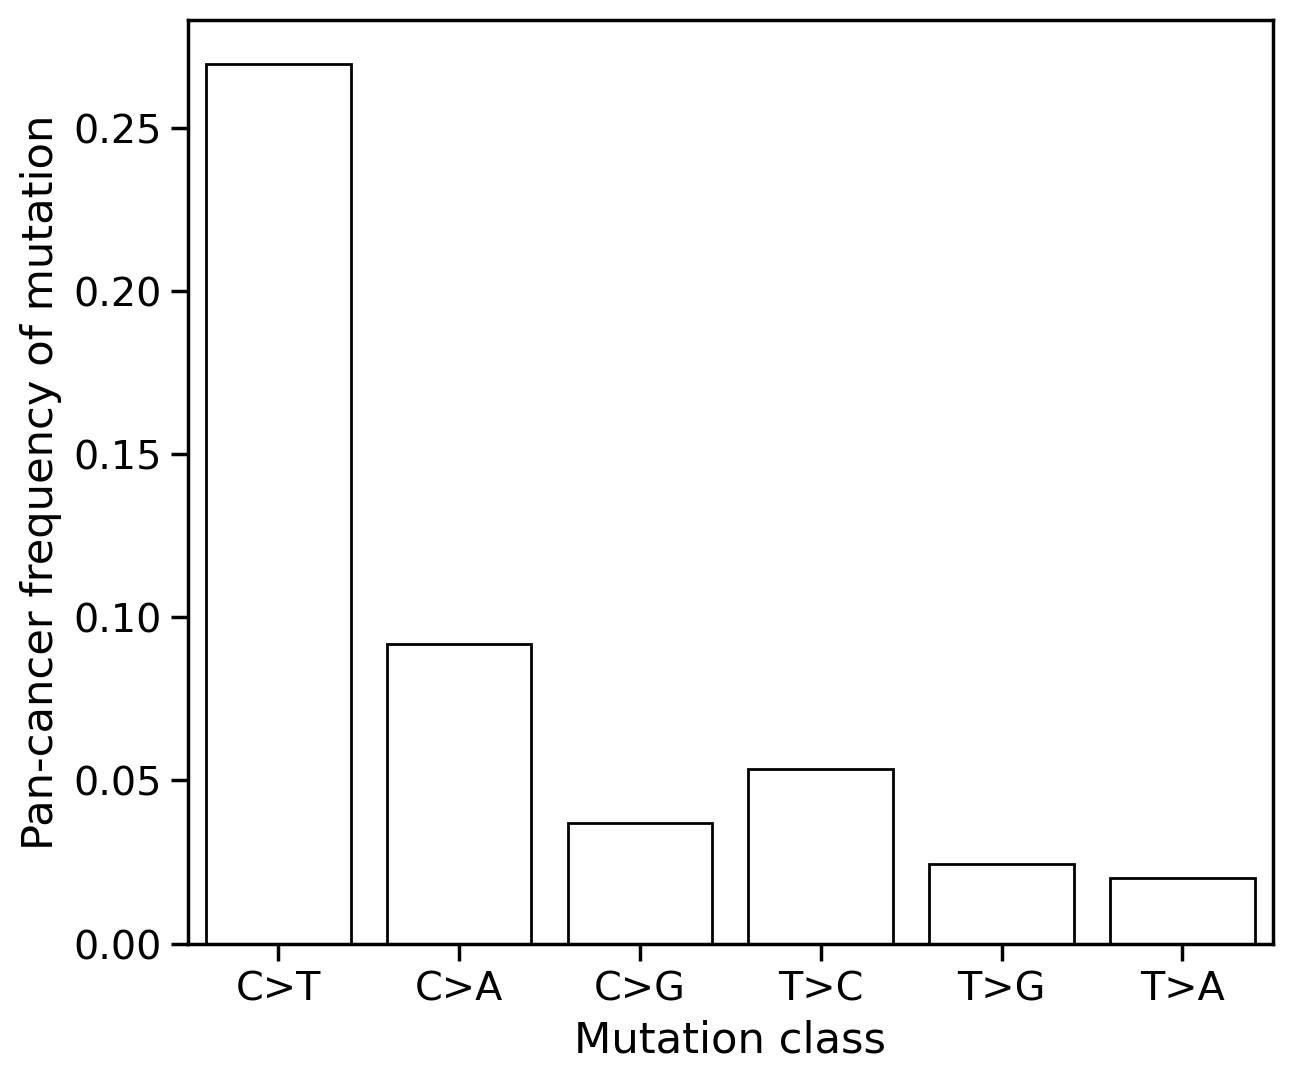

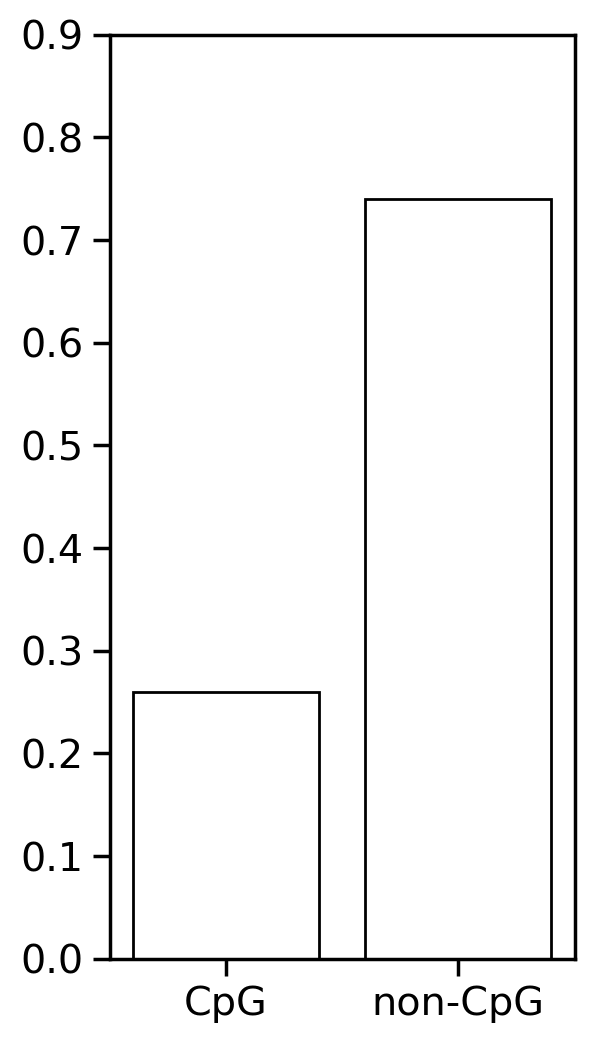

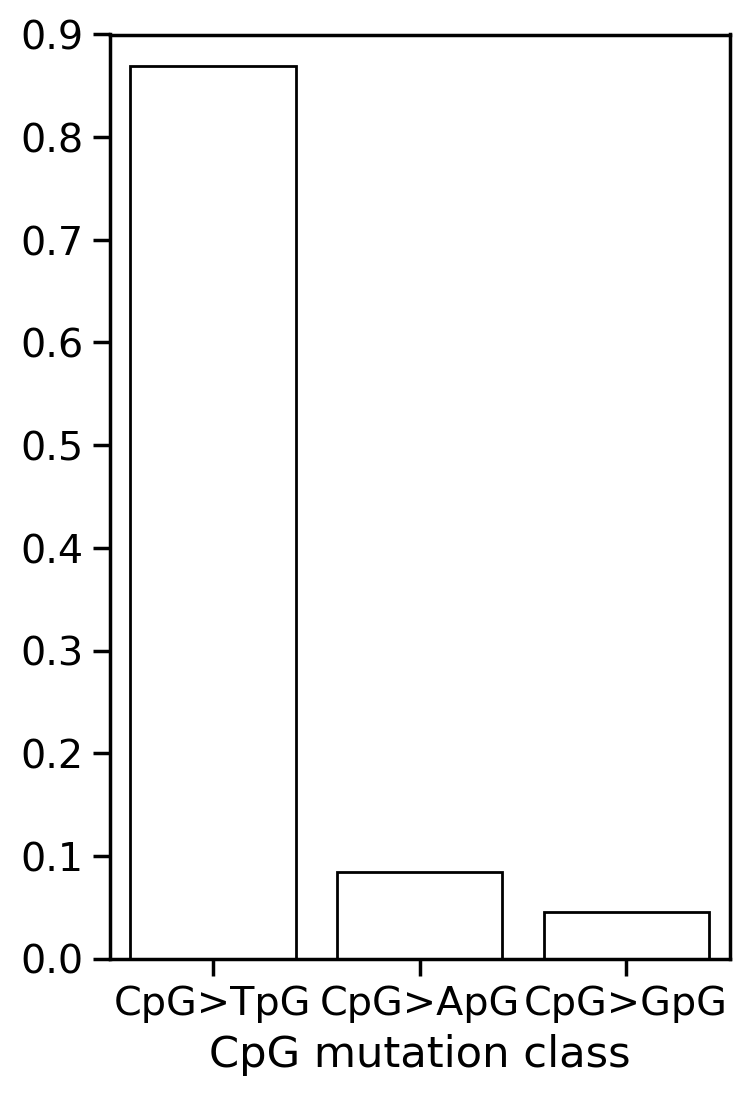

In [22]:
analysis.plot_mutations_distributions(all_mut_df, illumina_cpg_locs_df, all_methyl_df_t)

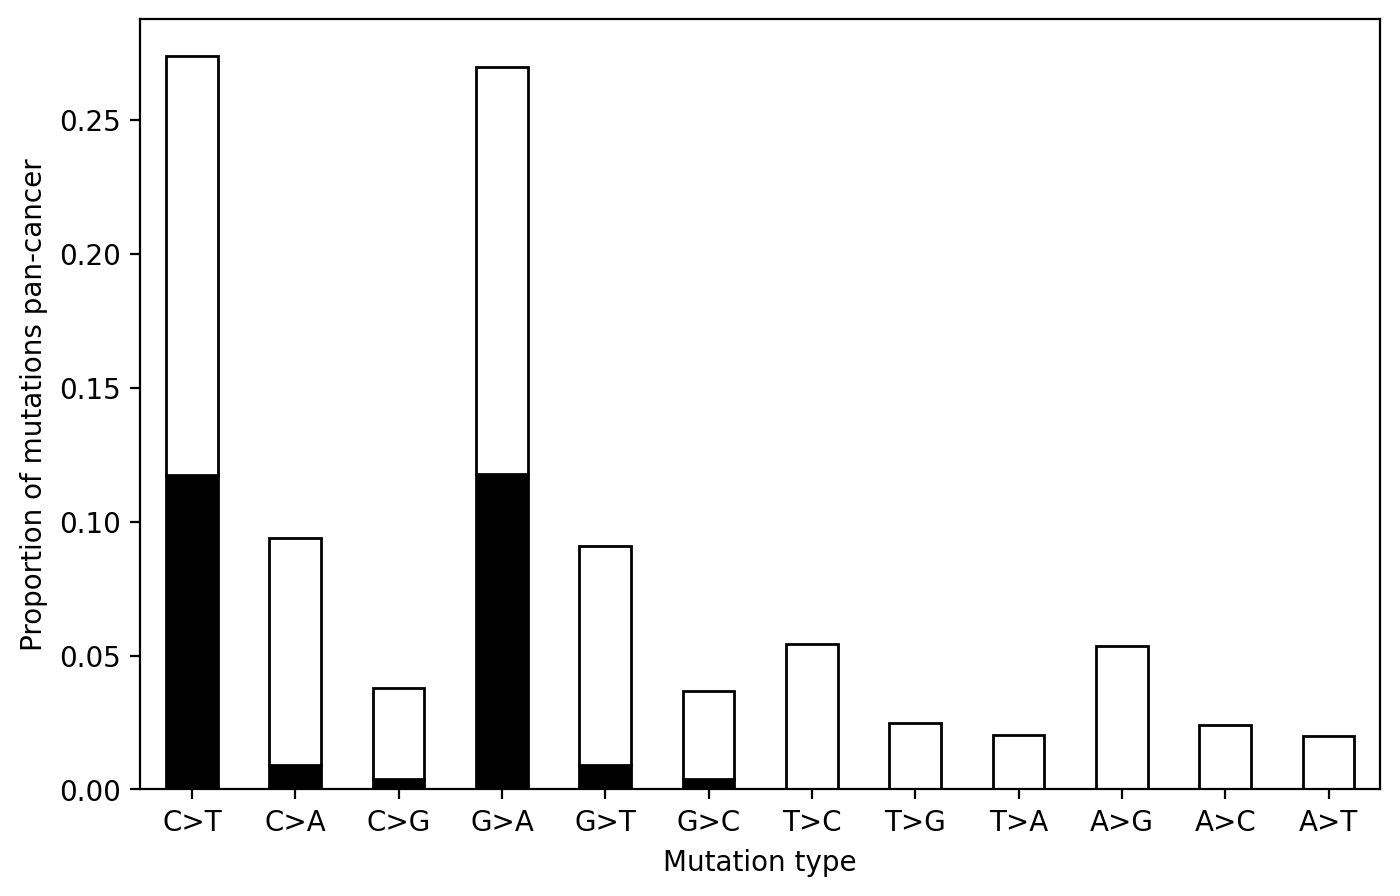

In [6]:
# number of rows with each type of mutation
mutation_counts = all_mut_df['mutation'].value_counts()
# for each mutation type, get the proportion where is_cpg is True and False
is_cpg_counts = all_mut_df.groupby(['mutation', 'is_cpg']).size().unstack(fill_value=0)
# divide the counts by the total number of mutations of that type
# rename columns 
is_cpg_counts.columns = ['Non-CpG', 'CpG']
is_cpg_counts = is_cpg_counts[['CpG', 'Non-CpG']]
"""# combine C>A and G>T mutations
is_cpg_counts.loc['C>A'] = is_cpg_counts.loc['C>A'] + mutation_counts['G>T']
is_cpg_counts = is_cpg_counts.drop('G>T')
# combine C>G and G>C mutations
is_cpg_counts.loc['C>G'] = is_cpg_counts.loc['C>G'] + mutation_counts['G>C']
is_cpg_counts = is_cpg_counts.drop('G>C')
# combine C>T and G>A mutations
is_cpg_counts.loc['C>T'] = is_cpg_counts.loc['C>T'] + mutation_counts['G>A']
is_cpg_counts = is_cpg_counts.drop('G>A')
# combine T>A and A>T mutations
is_cpg_counts.loc['T>A'] = is_cpg_counts.loc['T>A'] + mutation_counts['A>T']
is_cpg_counts = is_cpg_counts.drop('A>T')
# combine T>C and A>G mutations
is_cpg_counts.loc['T>C'] = is_cpg_counts.loc['T>C'] + mutation_counts['A>G']
is_cpg_counts = is_cpg_counts.drop('A>G')
# combine T>G and A>C mutations
is_cpg_counts.loc['T>G'] = is_cpg_counts.loc['T>G'] + mutation_counts['A>C']
is_cpg_counts = is_cpg_counts.drop('A>C')"""
# drop C>-
is_cpg_counts = is_cpg_counts.drop('C>-')
# convert counts to proportions of total mutation of any type
is_cpg_counts = is_cpg_counts.div(is_cpg_counts.sum(axis=1).sum(), axis=0)
# change order of rows
is_cpg_counts = is_cpg_counts.reindex(['C>T', 'C>A', 'C>G', 'G>A', 'G>T', 'G>C', 'T>C', 'T>G', 'T>A', 'A>G', 'A>C', 'A>T'])
# make the colors blue and red 
is_cpg_counts.plot.bar(stacked=True, figsize=(8,5), color=['black', 'white'], edgecolor='black', legend = False)

# add black edge around each bar

plt.ylabel('Proportion of mutations pan-cancer')
plt.xlabel('Mutation type')
# roate x labels
_ = plt.xticks(rotation=0)

In [9]:
is_cpg_counts.sum(axis=0)

CpG        0.261423
Non-CpG    0.738577
dtype: float64

In [11]:
is_cpg_counts

,CpG,Non-CpG
mutation,,
C>T,0.117543,0.156258
C>A,0.009058,0.084646
C>G,0.003970,0.034028
G>A,0.117946,0.151842
G>T,0.009048,0.082021
G>C,0.003859,0.032879
T>C,0.000000,0.054330
T>G,0.000000,0.024897
T>A,0.000000,0.020326


In [10]:
is_cpg_counts / is_cpg_counts.sum(axis=0)

,CpG,Non-CpG
mutation,,
C>T,0.449626,0.211566
C>A,0.034648,0.114607
C>G,0.015185,0.046073
G>A,0.451167,0.205587
G>T,0.034612,0.111053
G>C,0.014762,0.044517
T>C,0.000000,0.073561
T>G,0.000000,0.033709
T>A,0.000000,0.027521


In [12]:
0.449626 + 0.451167

0.900793

In [5]:
# load reference and CGI
from pyfaidx import Fasta
reference_genome = Fasta(
    '/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/hg19.fa'
    )
all_mut_df['seq'] = all_mut_df.apply(
    lambda x: reference_genome['chr'+x['chr']][x['start']-2: x['start'] + 1].seq,
    axis = 1)
all_mut_df['is_cpg'] = all_mut_df['seq'].str.contains('CG')
# save all_mut_df to parquet
all_mut_df.to_parquet(os.path.join(dependency_f_dir, 'all_mut_df_w_seq.parquet'))

# 1c: kde plot

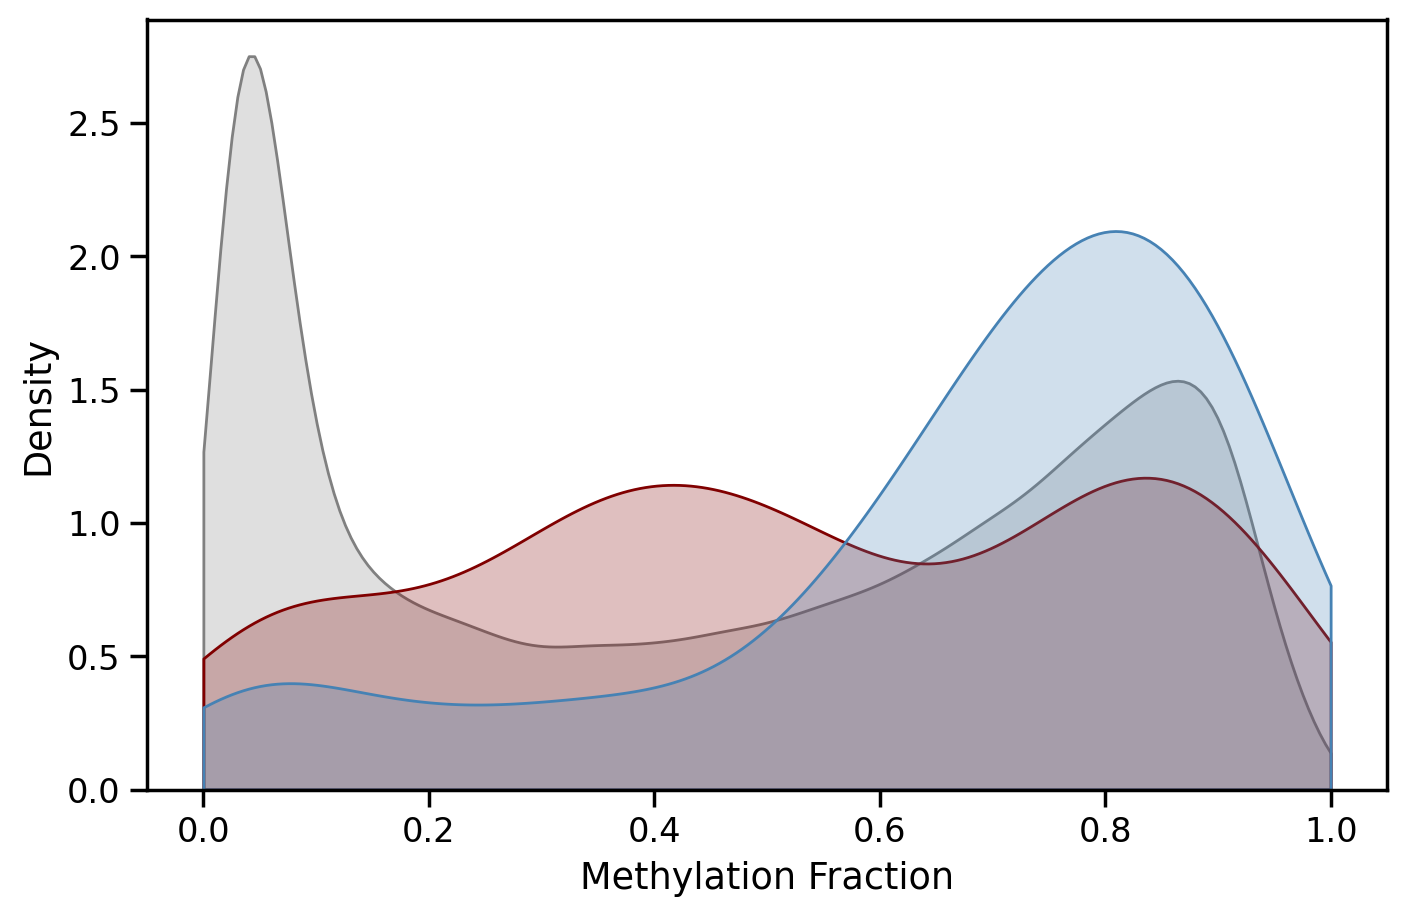

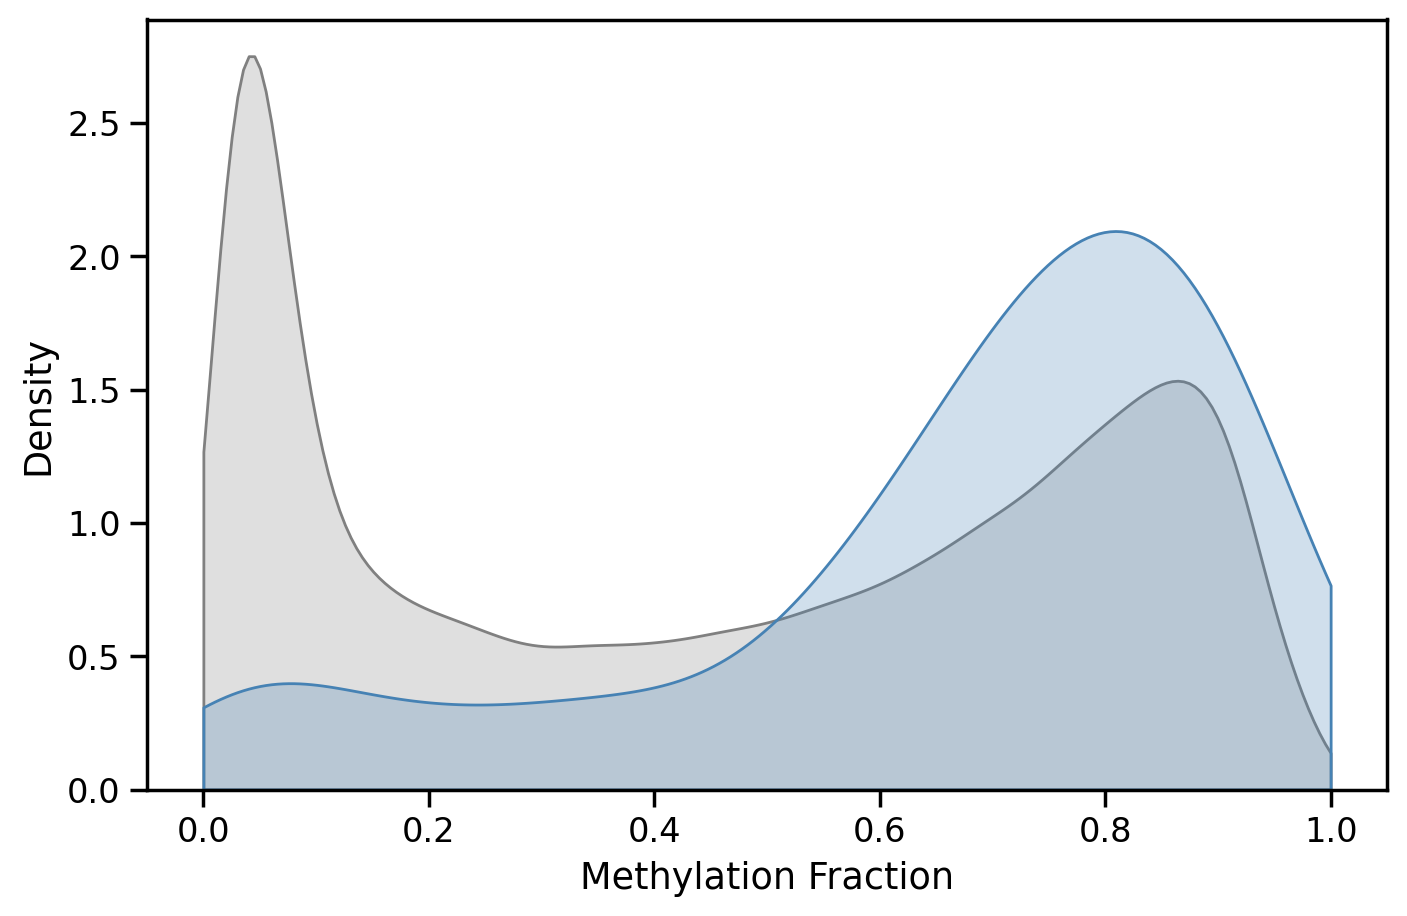

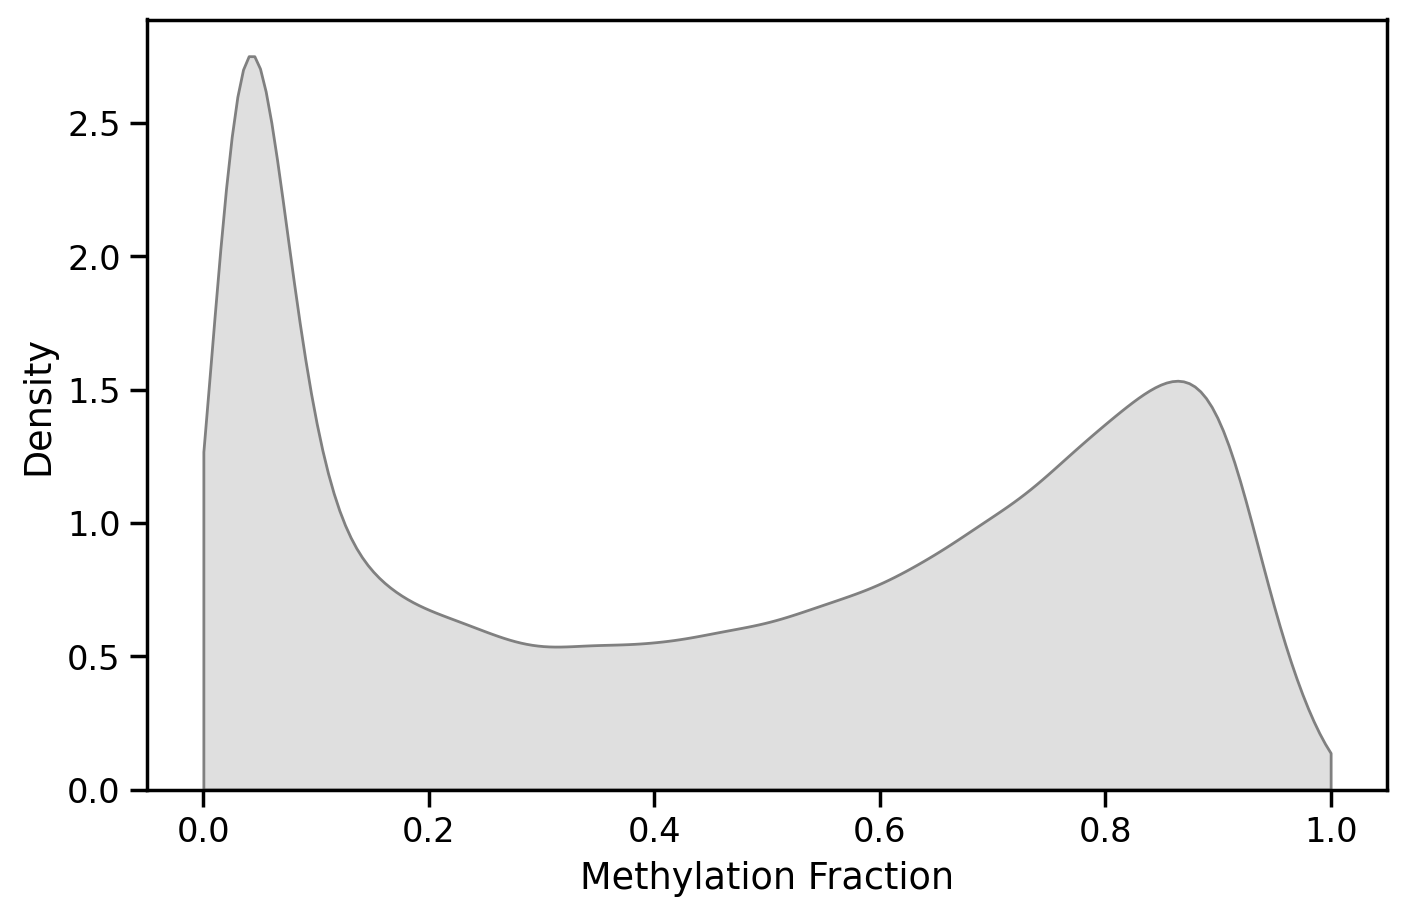

In [5]:
# old way >=.56 (top 5% of mutations)
mut_in_measured_cpg_w_methyl_age_df, to_plot_df = analysis.methylation_fraction_comparison(
    all_mut_df, illumina_cpg_locs_df, all_methyl_df_t,
    out_dir, all_meta_df
    )

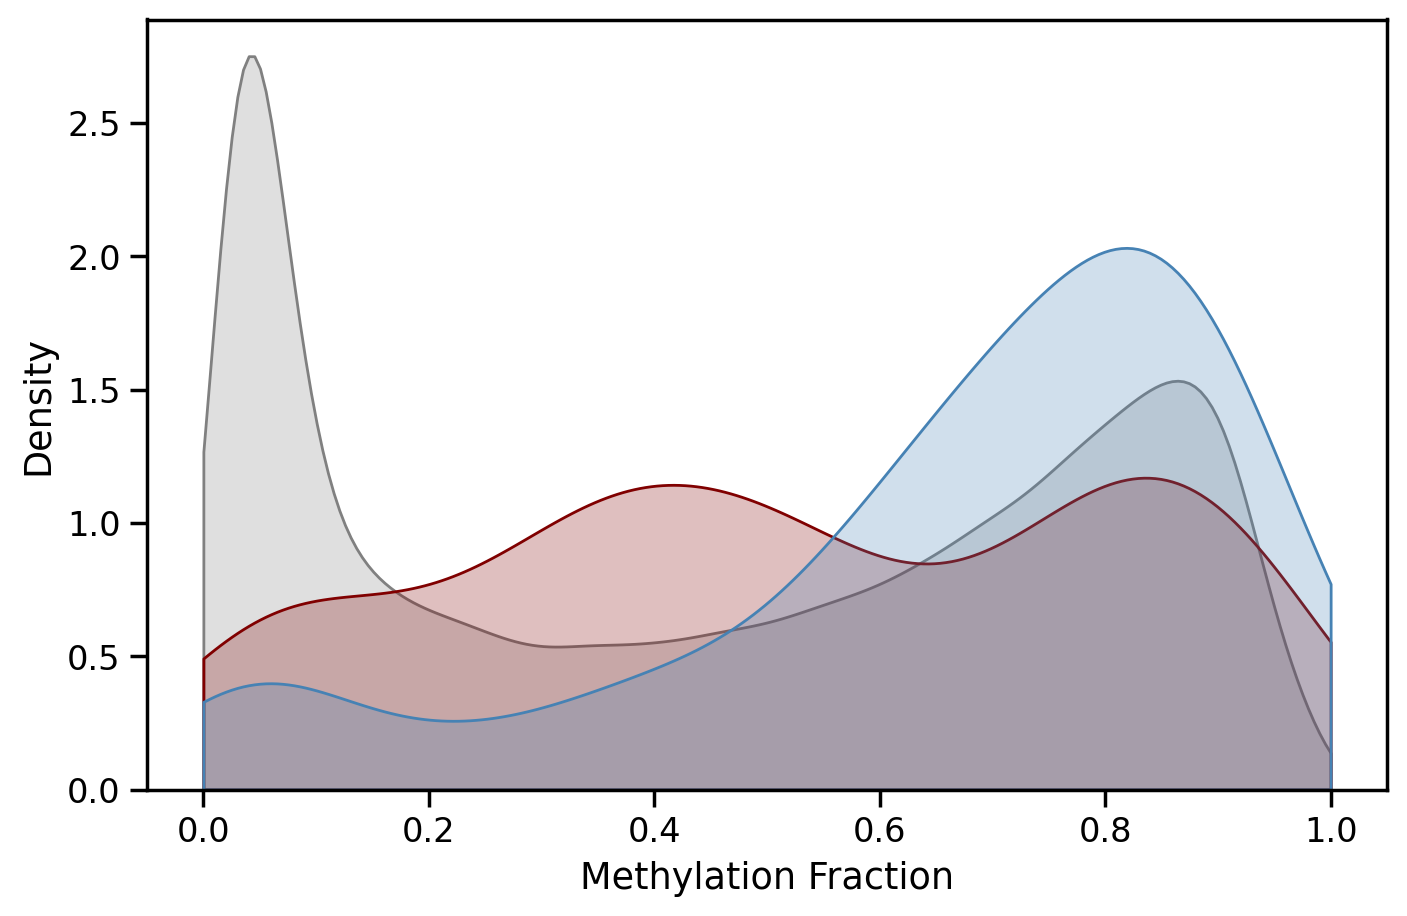

In [13]:
# new way >=.56 (top 5% of mutations)
mut_in_measured_cpg_w_methyl_age_df, to_plot_df = analysis.methylation_fraction_comparison(
    all_mut_df, illumina_cpg_locs_df, all_methyl_df_t,
    out_dir, all_meta_df
    )

In [30]:
# get the means of each Type in to_plot_df
to_plot_df['Type'].unique()

array(['Non mutated CpGs', 'Mutated CpGs', 'Site of no CpG mutation'],
      dtype=object)

In [29]:
stats.mannwhitneyu(
    to_plot_df.query('Type == "Non mutated CpGs"')['Methylation Fraction'], 
    to_plot_df.query('Type == "Site of no CpG mutation"')['Methylation Fraction']
    )

MannwhitneyuResult(statistic=51292291.0, pvalue=2.7323219459884468e-24)

In [31]:
stats.mannwhitneyu(
    to_plot_df.query('Type == "Non mutated CpGs"')['Methylation Fraction'], 
    to_plot_df.query('Type == "Mutated CpGs"')['Methylation Fraction']
    )

MannwhitneyuResult(statistic=52538.0, pvalue=3.87264825594618e-09)

In [32]:
stats.mannwhitneyu(
    to_plot_df.query('Type == "Site of no CpG mutation"')['Methylation Fraction'], 
    to_plot_df.query('Type == "Mutated CpGs"')['Methylation Fraction']
    )

MannwhitneyuResult(statistic=33913986.0, pvalue=0.0013963142273233774)

In [14]:
mut_in_measured_cpg_w_methyl_age_df.groupby('mutation')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
mutation,,,,,,,,
C>T,6984.0,-0.070359,0.158571,-0.765627,-0.167918,-0.02812,0.020951,0.700863


# D

In [54]:
pearsonr(mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'], mut_in_measured_cpg_w_methyl_age_df['difference'])

PearsonRResult(statistic=-0.19123604342712852, pvalue=1.6255981229139542e-58)

In [53]:
spearmanr(mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'], mut_in_measured_cpg_w_methyl_age_df['difference'])

SignificanceResult(statistic=-0.1545327072768897, pvalue=1.3917573511262687e-38)

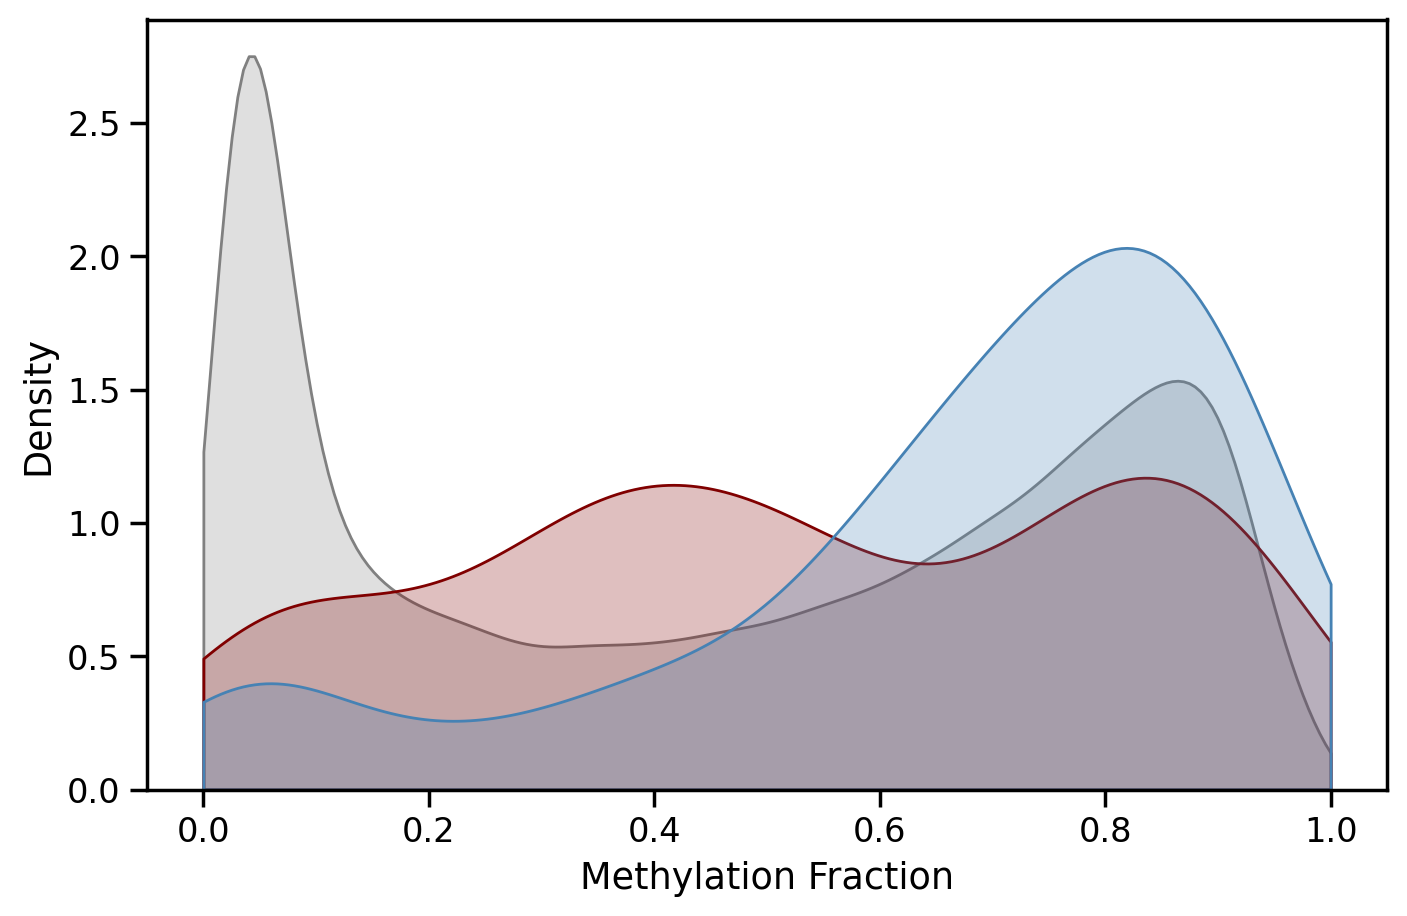

In [17]:
# new way >=.56 (top 5% of mutations)
mut_in_measured_cpg_w_methyl_age_df, to_plot_df = analysis.methylation_fraction_comparison(
    all_mut_df, illumina_cpg_locs_df, all_methyl_df_t,
    out_dir, all_meta_df
    )

In [18]:
# bin mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'] into 5 equal width bins from 0 to 1
mut_in_measured_cpg_w_methyl_age_df['VAF_bin'] = pd.cut(
                mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'],
                bins = 5,
                labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
                )

<Axes: xlabel='VAF_bin', ylabel='difference'>

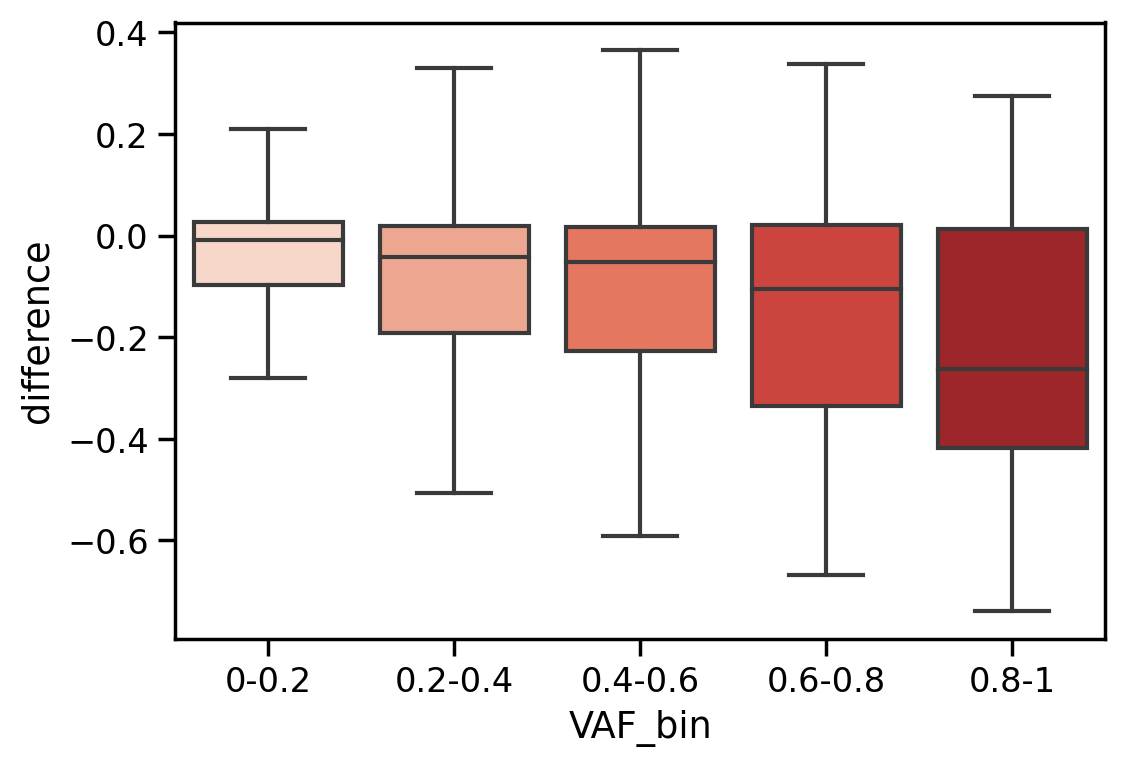

In [19]:
# new way
sns.set_context('notebook', font_scale=1.1)
# make bigger figure
plt.figure(figsize=(6,4), dpi=100)
sns.boxplot(data = mut_in_measured_cpg_w_methyl_age_df, x = 'VAF_bin', y = 'difference', showfliers=False, palette = 'Reds')

<Axes: xlabel='VAF_bin', ylabel='difference'>

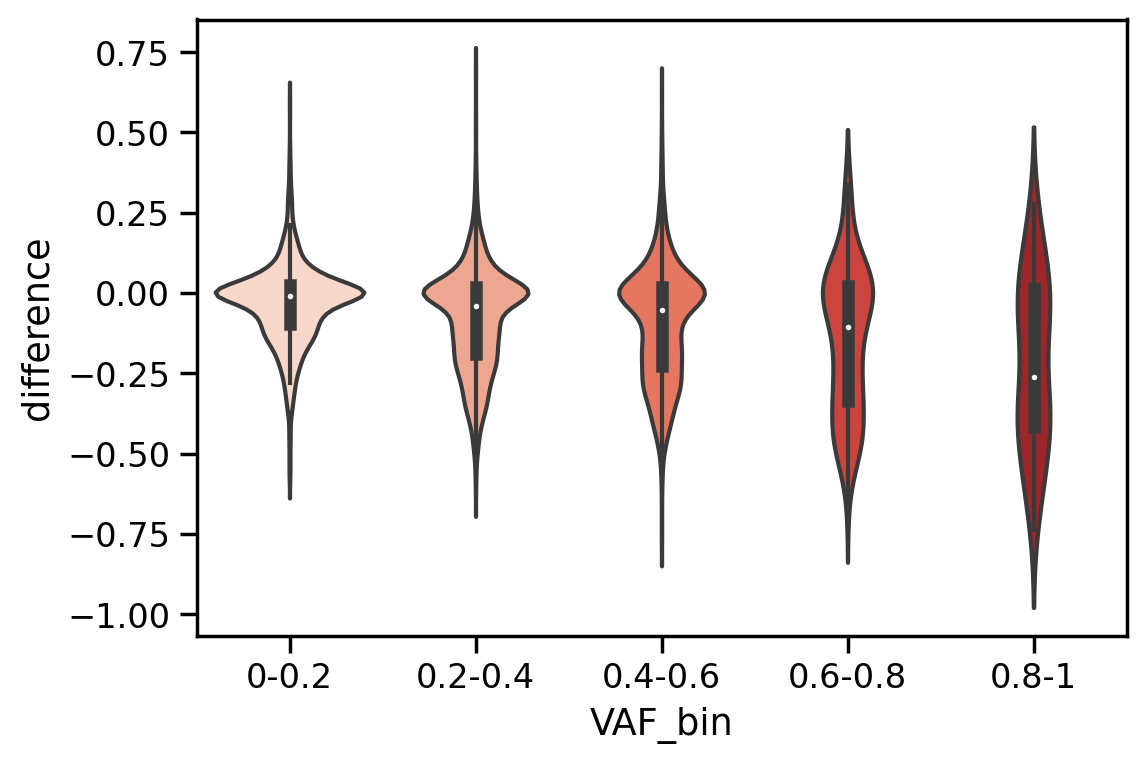

In [20]:
# new way
sns.set_context('notebook', font_scale=1.1)
# make bigger figure
plt.figure(figsize=(6,4), dpi=100)
sns.violinplot(data = mut_in_measured_cpg_w_methyl_age_df, x = 'VAF_bin', y = 'difference', showfliers=False, palette = 'Reds')